from google.colab import drive
drive.mount('/content/drive')

In [1]:
import os
import cv2
import numpy as np
from collections import defaultdict

import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling3D, GlobalMaxPool3D
from tensorflow.keras.layers import TimeDistributed, LSTM, Bidirectional, ConvLSTM2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
INPUT_PATH = "./CK+48/"

for dir_ in os.listdir(INPUT_PATH):
    count = 0
    if dir_==".DS_Store":
        continue
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
    print(f"{dir_} has {count} number of images")


happy has 207 number of images
fear has 75 number of images
surprise has 249 number of images
sadness has 84 number of images
anger has 135 number of images


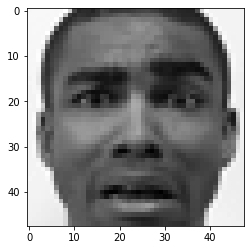

In [6]:
inp_pa = "./CK+48/fear/"
from skimage.io import imread
for dir in os.listdir(inp_pa):
    im = imread(inp_pa+dir)

    pyplot.imshow(im,cmap='gray')
  # print(type(im))

In [7]:
TOP_EMOTIONS = ["happy", "surprise", "anger", "sadness", "fear"]

In [8]:
INPUT_PATH = "./CK+48/"
data = defaultdict(str)
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        data[dir_] = defaultdict(list)
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            sub = f.split("_")[0]
            data[dir_][sub].append(f)

# data

In [9]:
from scipy.fftpack import dct

In [26]:
### Processing images into array form
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

def preprocess_list(x):
    return int((x.split("_")[2]).split(".")[0])

def preprocess_dict(x):
    res = list(np.argsort(list(map(preprocess_list, x))))
    return [x[i] for i in res]

def img2array(x,path):
    arr = np.empty(shape=(3,48,48))
    for i,f in enumerate(x):
        img = cv2.imread(path+f,0)
        imgF = dct2(img)
        imgF = imgF[0:48,0:48]
        imgF = imgF*3
        arr[i] = imgF
    return arr

In [27]:
for emotion in data:
    data[emotion] = dict((k, preprocess_dict(v)) for k, v in data[emotion].items())
    data[emotion] = dict((k, img2array(v, path=INPUT_PATH + emotion + "/")) for k, v in data[emotion].items())

# data

In [28]:
for k,v in data.items():
    print(f"{k} has {len(v)} samples")

happy has 69 samples
fear has 25 samples
surprise has 83 samples
sadness has 28 samples
anger has 45 samples


### Making a data of all images of emotions in separate array

In [29]:
surprise = np.stack(data["surprise"].values(), axis=0)
surprise = surprise.reshape(*surprise.shape,1)

happy = np.stack(data["happy"].values(), axis=0)
happy = happy.reshape(*happy.shape,1)

anger = np.stack(data["anger"].values(), axis=0)
anger = anger.reshape(*anger.shape,1)

sadness = np.stack(data["sadness"].values(), axis=0)
sadness = sadness.reshape(*sadness.shape,1)

fear = np.stack(data["fear"].values(), axis=0)
fear = fear.reshape(*fear.shape,1)

X = np.concatenate((surprise, happy, anger, sadness, fear))
y = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))
y = np_utils.to_categorical(y)

X.shape, y.shape

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


((250, 3, 48, 48, 1), (250, 5))

### Combining all 5 array 3 times

In [30]:
X1 = np.concatenate((surprise, happy, anger, sadness, fear,surprise, happy, anger, sadness, fear,surprise, happy, anger, sadness, fear))
y1 = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25),np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25),np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))
y1 = np_utils.to_categorical(y1)

print(X1.shape)
print(y1.shape)


(750, 3, 48, 48, 1)
(750, 5)


In [31]:
label_emotion_mapper = {0:"surprise", 1:"happy", 2:"anger", 3:"sadness", 4:"fear"}

In [32]:
# X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, train_size=0.8, stratify=y1, shuffle=True, random_state=42)
# X_train.shape, X_valid.shape
X_train = X1
y_train = y1


In [33]:
# y_train.shape,y_valid.shape

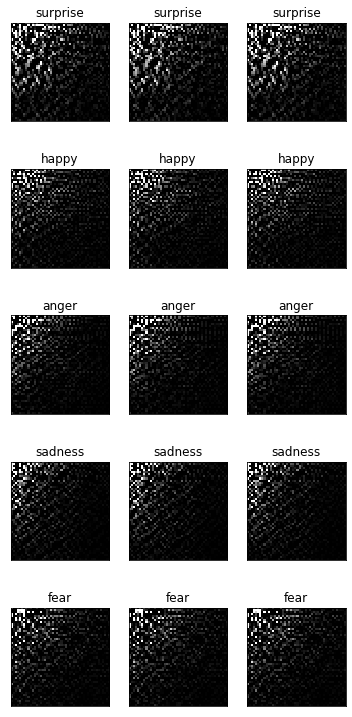

In [34]:
np.random.seed(42)
surprise_idx = np.random.choice(np.where(y_train[:, 0]==1)[0], size=1)
happy_idx = np.random.choice(np.where(y_train[:, 1]==1)[0], size=1)
anger_idx = np.random.choice(np.where(y_train[:, 2]==1)[0], size=1)
sad_idx = np.random.choice(np.where(y_train[:, 3]==1)[0], size=1)
fear_idx = np.random.choice(np.where(y_train[:, 4]==1)[0], size=1)

fig = pyplot.figure(1, (6,13))

i = 0
for name, idx in zip(label_emotion_mapper.values(), [surprise_idx, happy_idx, anger_idx, sad_idx, fear_idx]):
    for j in range(3):
        i += 1
        ax = pyplot.subplot(5,3,i)
        sample_img = X_train[idx][0,j,:,:,0]
        arr = np.asarray(sample_img)
        ax.imshow(arr, cmap='gray', vmin=0, vmax=255)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(name)

In [35]:
# data normalization
X_train = X_train / 255.
# X_valid = X_valid / 255.

X_train.shape #, X_valid.shape

(750, 3, 48, 48, 1)

In [22]:
def build_convlstm(input_shape, num_class, show_summary=True):
    net = Sequential(name='ConvLSTM2D')

    net.add(
        ConvLSTM2D(
            filters=32,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_1'
        )
    )
    
    net.add(BatchNormalization(name='batchnorm_1'))
    
    net.add(
        MaxPooling3D(
            pool_size=(1, 2, 2),
            padding='same',
            name='maxpool3d_1'
        )
    )
    
    net.add(
        ConvLSTM2D(
            filters=32,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_2'
        )
    )
    
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(
        MaxPooling3D(
            pool_size=(1, 2, 2),
            padding='same',
            name='maxpool3d_2'
        )
    )
    
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        ConvLSTM2D(
            filters=32,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_3'
        )
    )
   
    net.add(BatchNormalization(name='batchnorm_3'))
    
    net.add(
        MaxPooling3D(
            pool_size=(1, 2, 2),
            padding='same',
            name='maxpool3d_3'
        )
    )
    
    net.add(
        ConvLSTM2D(
            filters=32,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_4'
        )
    )

    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(
        MaxPooling3D(
            pool_size=(1, 2, 2),
            padding='same',
            name='maxpool3d_4'
        )
    )

    net.add(Dropout(0.4, name='dropout_2'))
    
    net.add(TimeDistributed(Flatten(name="flatten")))
    
    net.add(
        TimeDistributed(
            Dense(
                64,
                activation='elu',
                kernel_initializer='he_normal',
                name='dense_1'
            )
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))

    net.add(
          Dense(
              num_class,
              activation='softmax',
              name='out_layer'
          )
    )

    if show_summary:
        net.summary()

    return net

In [36]:
INPUT_SHAPE = (3, 48, 48, 1)
optim = optimizers.Adam(0.001)

model = build_convlstm(INPUT_SHAPE, num_class=5)
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['acc']
)

Model: "ConvLSTM2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convlstm2d_1 (ConvLSTM2D)    (None, 3, 48, 48, 32)     38144     
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 3, 48, 48, 32)     128       
_________________________________________________________________
maxpool3d_1 (MaxPooling3D)   (None, 3, 24, 24, 32)     0         
_________________________________________________________________
convlstm2d_2 (ConvLSTM2D)    (None, 3, 24, 24, 32)     73856     
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 3, 24, 24, 32)     128       
_________________________________________________________________
maxpool3d_2 (MaxPooling3D)   (None, 3, 12, 12, 32)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 12, 12, 32)     0

In [37]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.7,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
#     early_stopping,
    lr_scheduler,
]

batch_size = 32
epochs = 30

In [36]:
y_train_ = np.empty((y_train.shape[0], 3, 5))
for i in range(y_train.shape[0]):
    y_train_[i] = np.tile(y_train[i], (3,1))
    
# y_valid_ = np.empty((y_valid.shape[0], 3, 5))
# for i in range(y_valid.shape[0]):
#     y_valid_[i] = np.tile(y_valid[i], (3,1))

In [37]:
print(y_train[0])

[1. 0. 0. 0. 0.]


In [38]:
print(y_train_[0])

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [39]:
y_train_.shape #, y_valid_.shape

(750, 3, 5)

In [42]:
history = model.fit(
    x=X_train,
    y=y_train_,
    batch_size=batch_size,
    epochs=40,
    callbacks=callbacks,
    use_multiprocessing=True
)

Train on 750 samples
Epoch 1/40
750/750 [==============================] - 99s 132ms/sample - loss: 1.7023 - acc: 0.3493
Epoch 2/40
750/750 [==============================] - 96s 128ms/sample - loss: 1.0386 - acc: 0.6196
Epoch 3/40
750/750 [==============================] - 97s 129ms/sample - loss: 0.7450 - acc: 0.7324
Epoch 4/40
750/750 [==============================] - 97s 129ms/sample - loss: 0.5382 - acc: 0.8009
Epoch 5/40
750/750 [==============================] - 95s 127ms/sample - loss: 0.3869 - acc: 0.8596
Epoch 6/40
750/750 [==============================] - 97s 130ms/sample - loss: 0.2885 - acc: 0.9062
Epoch 7/40
750/750 [==============================] - 98s 131ms/sample - loss: 0.2142 - acc: 0.9373
Epoch 8/40
750/750 [==============================] - 96s 128ms/sample - loss: 0.1370 - acc: 0.9600
Epoch 9/40
750/750 [==============================] - 96s 128ms/sample - loss: 0.1226 - acc: 0.9631
Epoch 10/40
750/750 [==============================] - 104s 139ms/sample - loss

In [13]:
from tensorflow import keras
from keras.models import Model, load_model, loadLayersModel

ImportError: cannot import name 'loadLayersModel' from 'keras.models' (/opt/anaconda3/lib/python3.7/site-packages/keras/models.py)

In [47]:
model.save('./Emotion_CNN.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['acc'], label='train')
# sns.lineplot(history.epoch, history.history['val_acc'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
# sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()

In [ ]:
path = "../content/drive/MyDrive/CK+48/fear/"
for dir_ in os.listdir(path):
  img = cv2.imread(path+dir_, 0)
print(img.shape)

In [76]:
predi = classifierLoad.predict(X_train)

In [77]:
predi.shape

(750, 3, 5)

In [79]:
predi[110]

array([[4.8781277e-07, 9.9998438e-01, 1.2608976e-05, 1.9590702e-07,
        2.3055163e-06],
       [4.3492285e-08, 9.9999940e-01, 4.4432414e-07, 2.0396090e-08,
        1.7582623e-07],
       [3.2417159e-08, 9.9999940e-01, 3.9390287e-07, 2.9791945e-08,
        2.2264301e-07]], dtype=float32)

In [95]:
predictions = []
for i in range(0,749):
    result = predi[i].sum(axis=0)
    j = np.unravel_index(result.argmax(),result.shape)
#     print(j[0])
    predictions.append(j[0])


In [98]:
print(predictions)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

(1,)
